In [13]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from typing import Callable, List

matplotlib.rcParams.update({'font.size': 18})

# Problem 1

We have for the non-adaptive method that:
\begin{align*}
x(t+H) &= R_{n,m} + c_mh_n^{2m} + O(h_n^{2m+2}) \\
c_mh_n^{2m} &= \frac{R_{n,m} - R_{n-1,m}}{[n/(n-1)]^{2m} - 1}
\end{align*}
so
\begin{equation*}
R_{n,m+1} = R_{n,m} + \frac{R_{n,m} - R_{n-1,m}}{[n/(n-1)]^{2m} - 1}
\end{equation*}

### Define the modified midpoint method

In [2]:
def mod_mid(df: Callable, H: float, n: int, x0: List):
    h = H/n
    r1 = x0 + 0.5*h*df(x0)
    r2 = x0 + h*df(r1)
    for i in range(n-1):
        r1 += h*df(r2)
        r2 += h*df(r1)  
    return 0.5*(r1 + r2 + 0.5*h*df(r2))

### Recursive function to calculate $R_{n,m}$

In [3]:
def R(df: Callable, H: float, n: int, m: int, x0: List):
    if m == 1:
        return (mod_mid(df, H, n, x0), np.inf*np.ones(x0.shape))
    else:
        R_n1m1 = R(df, H, n-1, m-1, x0)[0]
        R_nm1 = R(df, H, n, m-1, x0)[0]
        error = (R_nm1 - R_n1m1) / (np.power(n/(n-1), 2*(m-1)) - 1)
        return (R_nm1 + error, error)

### Function that tries to solve for $x(t + H)$ using Bulirsch-Stoer and returns `None` if $n$ gets too large

In [4]:
def x(df: Callable, H: float, x0: List, delta=1e-10, max_n=np.inf):
    n = 1
    r, error = R(df, H, n, n, x0)
    
    while (abs(error) > H*delta).any():
        n += 1
        r, error = R(df, H, n, n, x0)
        if n > max_n or (abs(error) > 1e8).any():
            return None
    return r

### The adaptive implementation of Bulirsch-Stoer that subdivides intervals if necessary

In [5]:
def adaptive_x(df, H, x0, delta=1e-10, max_n=8):
    h = H
    next_val = x(df, h, x0, delta=delta, max_n=max_n)
    while next_val is None:
        h = h / 2
        next_val = x(df, h, x0, delta=delta, max_n=max_n)
    return (next_val, h)

### The definition of our diff eq and the corresponding solution curves

In [6]:
def df(vec):
    a = 1
    b = 3
    dx = 1 - (b +1)*vec[0] + a*vec[0]**2 * vec[1]
    dy = b*vec[0] - a*vec[0]**2 * vec[1]
    return np.array([dx, dy])

a = 0
b = 20

x0 = np.array([0, 0])
x_vals = [x0]

N = 1
for _ in range(N):
    h_left = (b-a)/N
    while h_left > 0:
        next_step = adaptive_x(df, h_left, x_vals[-1], delta=1e-10)
        x_vals.append(next_step[0])
        h_left -= next_step[1]
x_vals = np.array(x_vals)
print(x_vals.shape)

(143, 2)


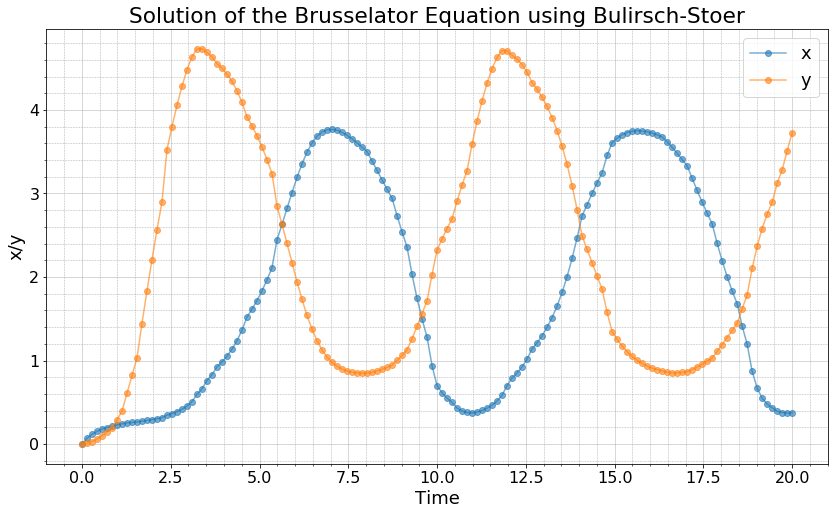

In [17]:
fig = plt.figure()
fig.set_size_inches(14,8)
ax = fig.add_subplot()
ax.plot(np.linspace(a, b, x_vals.shape[0]), x_vals[:, 0], '-o', alpha=0.6, label="x")
ax.plot(np.linspace(a, b, x_vals.shape[0]), x_vals[:, 1], '-o', alpha=0.6, label="y")

ax.set_xlabel("Time")
ax.set_ylabel("x/y")
ax.set_title("Solution of the Brusselator Equation using Bulirsch-Stoer")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
ax.legend()
fig.savefig("prob1.png")

# Problem 2

Units are:
- Distance: 100 Parsecs
- Time: 

and we assume $G = M = 1$ so $r_s \approx 10^{-7}$.
\begin{align*}
\frac{d^2\mathbf{r}_{BH}}{dt^2} &= -\frac{GM_{BH}}{4r^3_{BH}}\mathbf{r}_{BH} + \dot{\mathbf{v}}_{DF} \\
\dot{\mathbf{v}}_{DF} &= -\frac{A}{v^3_{BH} + B}\mathbf{v}_{BH} \\
\mathbf{r}_0 &= (1,0) \\
\mathbf{v}_0 &= 0.8 \mathbf{v}_{circ} \implies v_0 = \frac{2}{5\sqrt{r_0}} \\
\hat{\mathbf{v}}_0 &= R(-\pi/2)\hat{\mathbf{r}}_0 = \frac{1}{r_0}(y_0, -x_0) \\
\mathbf{v}_0 &= \frac{2}{5r_0^{3/2}}(y_0, -x_0)
\end{align*}
Then for $x(t+2h) = x_2$ and $x(t+h) = x_1$ both obtained by RK4, we have that the next optimal step size is
$$h' = h\rho^{1/4}$$
where
$$\rho = \frac{h\delta}{\lVert\boldsymbol{\epsilon}\rVert} = \frac{30h\delta}{\lVert\mathbf{r}_1 - \mathbf{r}_2\rVert}$$
and
$$\boldsymbol{\epsilon} = (\epsilon_x, \epsilon_y) = \frac{1}{30}(|x_1 - x_2|, |y_1 - y_2|)$$
If $\rho < 1$ update $h$ and redo that step. If $\rho >= 1$ then keep the value obtained from two steps of $h$ and now update $h$ and continue.

In [18]:
def rk4_step(f: Callable, r: np.array, t: float, h: float, **kwargs):
    k1 = h*f(r, t, **kwargs)
    k2 = h*f(r + 0.5*k1, t + 0.5*h, **kwargs)
    k3 = h*f(r + 0.5*k2, t + 0.5*h, **kwargs)
    k4 = h*f(r + k3, t + h, **kwargs)
    return r + (k1 + 2*k2 + 2*k3 + k4)/6

In [19]:
def get_rho(r1: np.array, r2: np.array, h: float, delta: float):
    pos1 = r1[:2]
    pos2 = r2[:2]
    if (pos1 == pos2).all():
        return 1
    return 30*h*delta / np.linalg.norm(pos1 - pos2)

In [26]:
# r = x, y, vx, vy
def f_no_fric(r: np.array, t: float, **kwargs):
    pos = r[:2]
    v = r[2:4]
    return np.hstack([v, -1 * pos / (4 * np.linalg.norm(pos)**3)])

In [27]:
def f_fric(r: np.array, t: float, A=1, B=1):
    pos = r[:2]
    v = r[2:4]
    dv = -1*A*v / (pow(np.linalg.norm(v), 3) + B)
    return f_no_fric(r, t) + np.hstack([np.zeros(2), dv])

In [28]:
def adaptive_RK4(f: Callable, r0: np.array, t0: float, h0: float, total_time: float = None,
                 stop_at: float = None, delta=1e-8, A=1, B=1):
    if total_time is None and stop_at is None:
        total_time = h0
    elif total_time is None:
        total_time = np.inf
    results = [r0]
    times = [t0]
    cur_time = t0
    r = r0
    h = h0
    while cur_time < total_time + t0:
        r1_half = rk4_step(f, r, cur_time, h, A=A, B=B)
        r1 = rk4_step(f, r1_half, cur_time + h, h, A=A, B=B)
        r2 = rk4_step(f, r, cur_time, 2*h, A=A, B=B)
        rho = get_rho(r1, r2, h, delta)
        rho = rho if rho <= 16 else 16 # limit h to grow by a factor of 2 or less
        if rho >= 1:
            results.append(r1_half)
            results.append(r1)
            times.append(cur_time + h)
            times.append(cur_time + 2*h)
            cur_time += 2*h
            r = r1
            if stop_at is not None:
                distance = np.linalg.norm(r[:2])
                if distance < stop_at or abs((distance - stop_at)/stop_at) < 0.05:
                    break
        h *= pow(rho, 1/4)
    return np.vstack(results), times

## part (a)
We have $G = M = 1$, $r_{per} = 10^{-7}$, $r_{ap} = 1$
\begin{align*}
\mu &= \frac{G(M_1 + M_2)}{4} = 1/2 \\
a &= (r_{per} + r_{ap})/2 \\
e &= \frac{r_{ap} - r_{per}}{r_{ap} + r_{per}} \\
v_{ap} &= \sqrt{\frac{(1 - e)\mu}{(1+e)a}}
\end{align*}

In [29]:
# For the initial conditions
x0 = 1
y0 = 0
r_per = 1e-7
r_ap = x0
mu = 1/4
a = (r_per + r_ap)/2
e = (r_ap - r_per)/(r_ap + r_per)
v0 = np.sqrt((1-e)*mu/r_ap)
T = 2*np.pi*np.sqrt(a**3 / mu)
v0, T

(0.00022360678658179, 4.442883604590824)

In [30]:
mag_pos = np.sqrt(x0**2 + y0**2)
r0 = np.array([x0, y0, v0*y0/mag_pos, -v0*x0/mag_pos])
r0

array([ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.23606787e-04])

In [36]:
rk4_results1, times1 = adaptive_RK4(f_no_fric, r0, 0, T/5, total_time=11*T, delta=1e-6)

In [37]:
rk4_results2, times2 = adaptive_RK4(f_no_fric, r0, 0, T/5, total_time=11*T, delta=1e-7)

In [38]:
rk4_results3, times3 = adaptive_RK4(f_no_fric, r0, 0, T/5, total_time=11*T, delta=1e-8)

In [39]:
(rk4_results3[:, 0]**2 + rk4_results3[:, 1]**2)

array([1.        , 0.99749539, 0.98998787, ..., 0.99751188, 1.00024054,
       0.99975151])

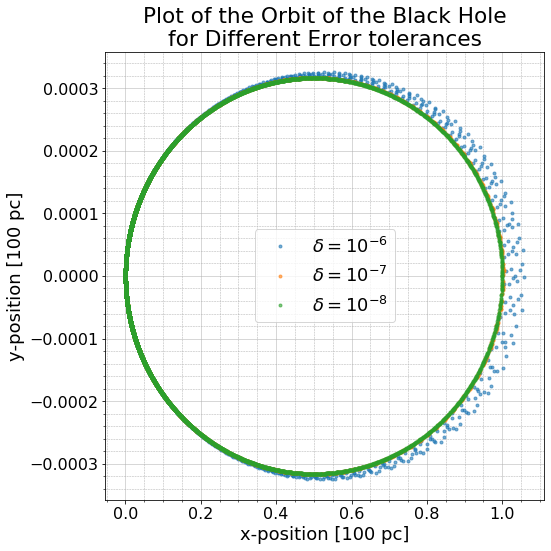

In [97]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot()
ax.plot(rk4_results1[:, 0], rk4_results1[:, 1], '.', alpha=0.6, label="$\delta = 10^{-6}$")
ax.plot(rk4_results2[:, 0], rk4_results2[:, 1], '.', alpha=0.6, label="$\delta = 10^{-7}$")
ax.plot(rk4_results3[:, 0], rk4_results3[:, 1], '.', alpha=0.6, label="$\delta = 10^{-8}$")

ax.set_xlabel("x-position [100 pc]")
ax.set_ylabel("y-position [100 pc]")
ax.set_title("Plot of the Orbit of the Black Hole\nfor Different Error tolerances")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
ax.legend()
fig.tight_layout()
fig.savefig("prob2_a_orbit.png")

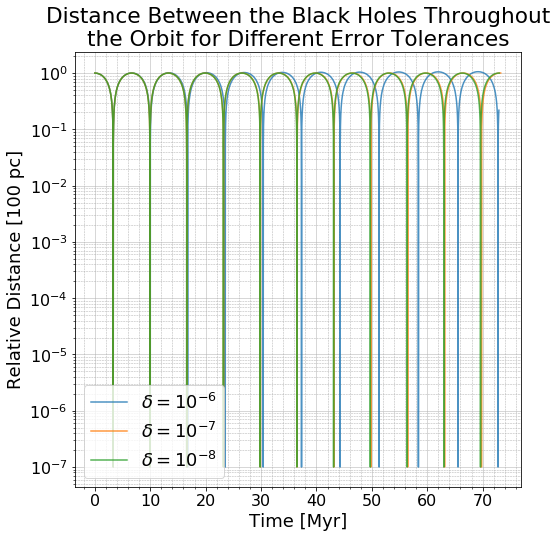

In [56]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot()
ax.plot(1.492*np.array(times1), np.sqrt(rk4_results1[:, 0]**2 + rk4_results1[:, 1]**2), '-', alpha=0.8,
        label="$\delta = 10^{-6}$")
ax.plot(1.492*np.array(times2), np.sqrt(rk4_results2[:, 0]**2 + rk4_results2[:, 1]**2), '-', alpha=0.8,
        label="$\delta = 10^{-7}$")
ax.plot(1.492*np.array(times3), np.sqrt(rk4_results3[:, 0]**2 + rk4_results3[:, 1]**2), '-', alpha=0.8,
        label="$\delta = 10^{-8}$")

ax.set_xlabel("Time [Myr]")
ax.set_ylabel("Relative Distance [100 pc]")
ax.set_title("Distance Between the Black Holes Throughout\nthe Orbit for Different Error Tolerances")
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
ax.legend(loc="lower left")
fig.savefig("prob2_a_logr.png")

## part (b)

In [59]:
# For the initial conditions
x0 = 1
y0 = 0
v0 = 2/5
mag_pos = np.sqrt(x0**2 + y0**2)
r0 = np.array([x0, y0, v0*y0/mag_pos, -v0*x0/mag_pos])
r0

array([ 1. ,  0. ,  0. , -0.4])

In [67]:
rk4_results, times = adaptive_RK4(f_fric, r0, 0, T/10, total_time=None, stop_at=1e-7, delta=1e-8)

In [81]:
rk4_results_largev, times_largev = adaptive_RK4(f_fric, np.array([x0, y0, 5*v0*y0/mag_pos, -5*v0*x0/mag_pos]),
                                         0, T/10, total_time=100*T, stop_at=1e-7, delta=1e-8)

In [84]:
rk4_results_smallv, times_smallv = adaptive_RK4(f_fric, np.array([x0, y0, 1e-5*v0*y0/mag_pos, -1e-5*v0*x0/mag_pos]),
                                         0, T/10, total_time=None, stop_at=1e-7, delta=1e-8)

In [70]:
rk4_results.shape

(86717, 4)

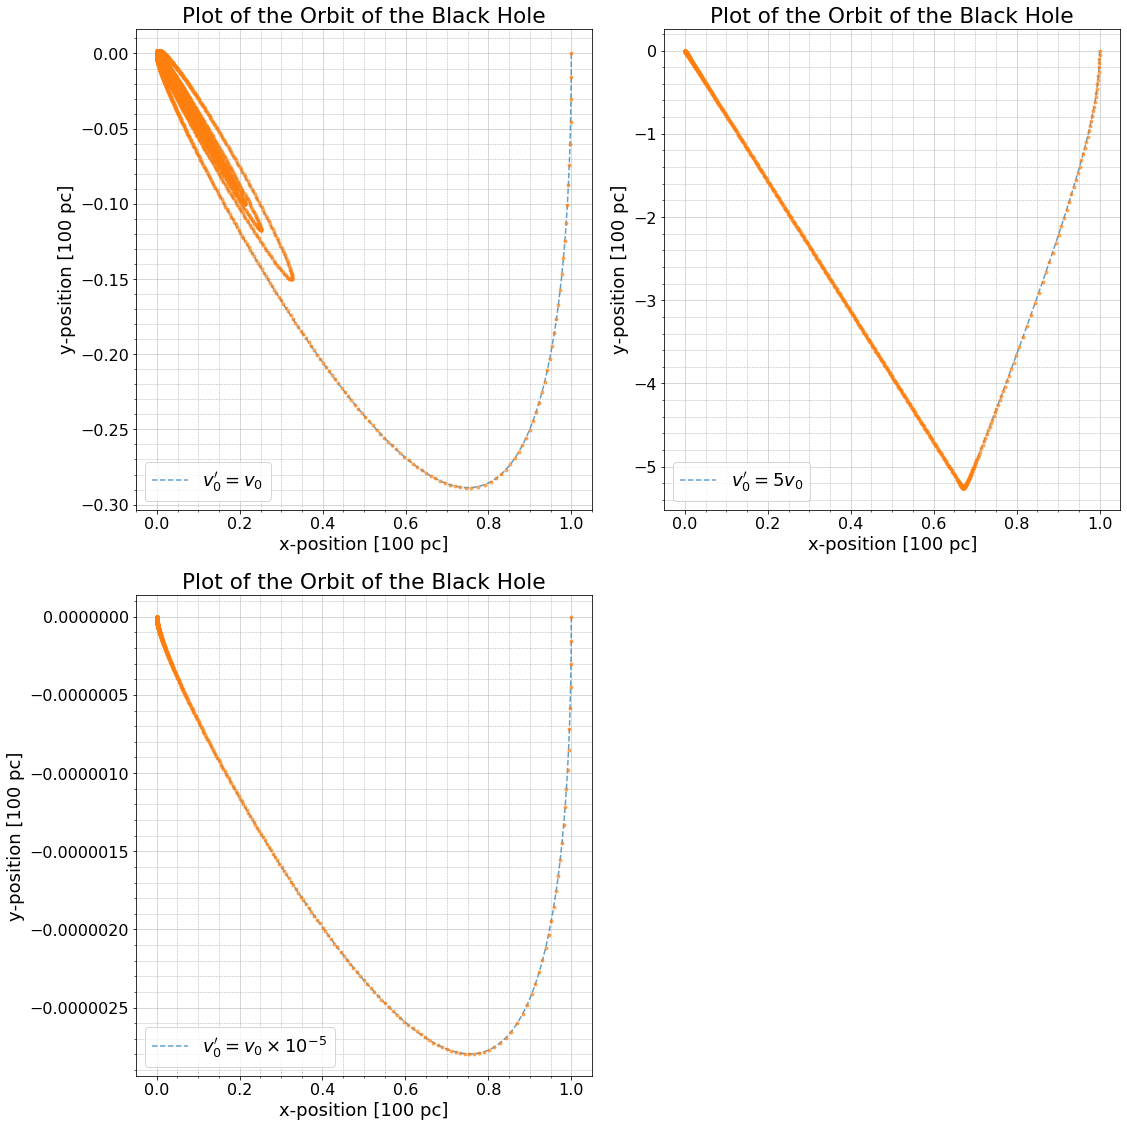

In [90]:
fig = plt.figure()
fig.set_size_inches(16,16)
ax = fig.add_subplot(221)

ax.plot(rk4_results[:, 0], rk4_results[:, 1], '--', alpha=0.7, label="$v_0' = v_0$")
ax.plot(rk4_results[:, 0], rk4_results[:, 1], '.', alpha=0.6)

ax.set_xlabel("x-position [100 pc]")
ax.set_ylabel("y-position [100 pc]")
ax.set_title("Plot of the Orbit of the Black Hole")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
ax.legend()

ax = fig.add_subplot(222)

ax.plot(rk4_results_largev[:, 0], rk4_results_largev[:, 1], '--', alpha=0.7, label="$v_0' = 5v_0$")
ax.plot(rk4_results_largev[:, 0], rk4_results_largev[:, 1], '.', alpha=0.6)

ax.set_xlabel("x-position [100 pc]")
ax.set_ylabel("y-position [100 pc]")
ax.set_title("Plot of the Orbit of the Black Hole")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
ax.legend()

ax = fig.add_subplot(223)

ax.plot(rk4_results_smallv[:, 0], rk4_results_smallv[:, 1], '--', alpha=0.7, label=r"$v_0' = v_0 \times 10^{-5}$")
ax.plot(rk4_results_smallv[:, 0], rk4_results_smallv[:, 1], '.', alpha=0.6)

ax.set_xlabel("x-position [100 pc]")
ax.set_ylabel("y-position [100 pc]")
ax.set_title("Plot of the Orbit of the Black Hole")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
ax.legend()

fig.tight_layout()
fig.savefig("prob2_b_orbit.png")

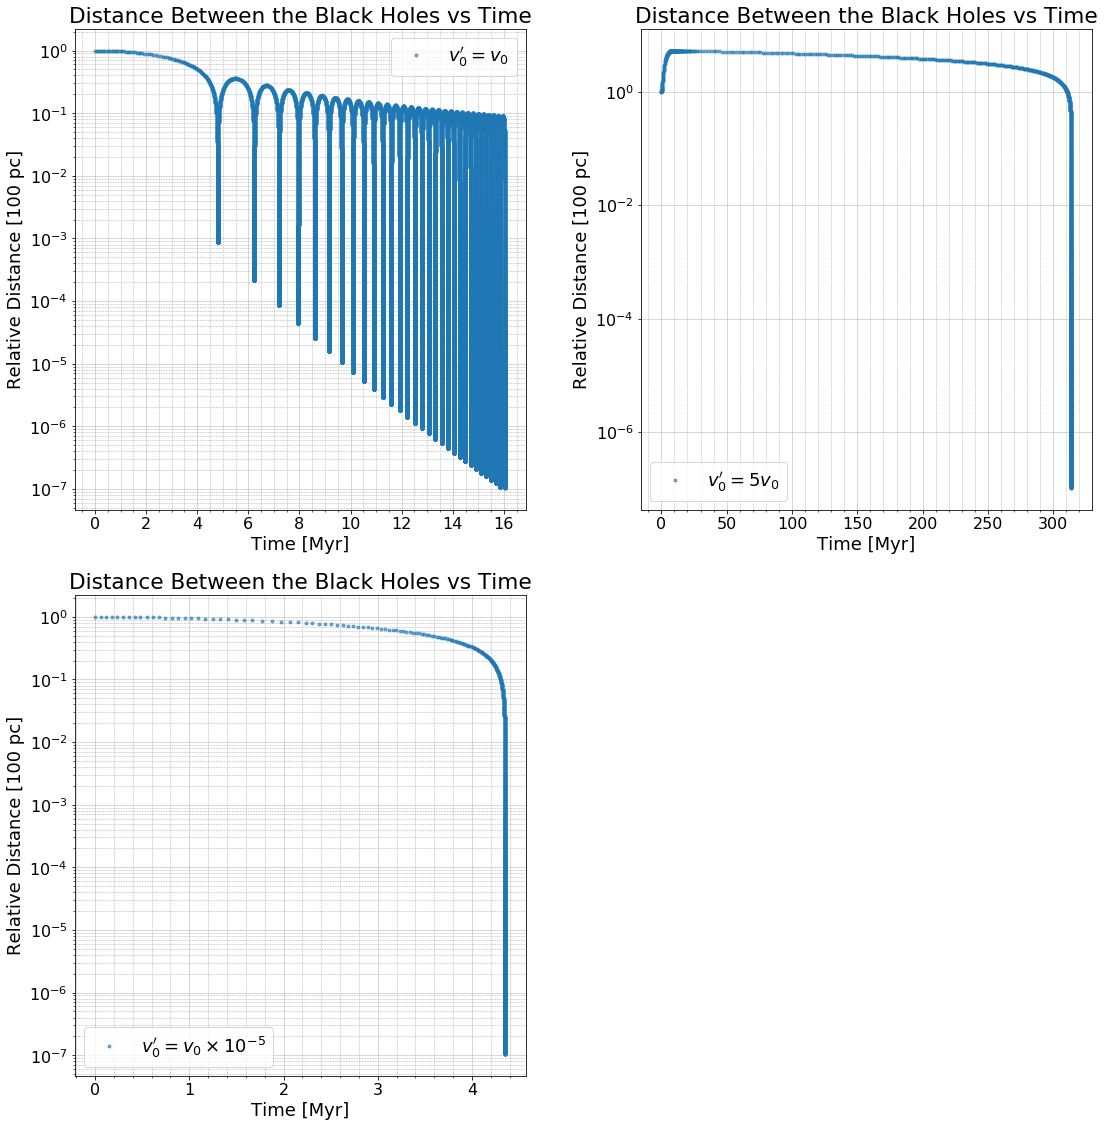

In [99]:
fig = plt.figure()
fig.set_size_inches(16,16)
ax = fig.add_subplot(221)

ax.plot(1.492*np.array(times), np.sqrt(rk4_results[:, 0]**2 + rk4_results[:, 1]**2), '.', alpha=0.6,
        label="$v_0' = v_0$")

ax.set_xlabel("Time [Myr]")
ax.set_ylabel("Relative Distance [100 pc]")
ax.set_title("Distance Between the Black Holes vs Time")
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
ax.legend()

ax = fig.add_subplot(222)

ax.plot(1.492*np.array(times_largev), np.sqrt(rk4_results_largev[:, 0]**2 + rk4_results_largev[:, 1]**2), '.',
        alpha=0.6, label="$v_0' = 5v_0$")

ax.set_xlabel("Time [Myr]")
ax.set_ylabel("Relative Distance [100 pc]")
ax.set_title("Distance Between the Black Holes vs Time")
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
ax.legend()

ax = fig.add_subplot(223)

ax.plot(1.492*np.array(times_smallv), np.sqrt(rk4_results_smallv[:, 0]**2 + rk4_results_smallv[:, 1]**2), '.',
        alpha=0.6, label=r"$v_0' = v_0 \times 10^{-5}$")

ax.set_xlabel("Time [Myr]")
ax.set_ylabel("Relative Distance [100 pc]")
ax.set_title("Distance Between the Black Holes vs Time")
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
ax.legend()

fig.tight_layout()
fig.savefig("prob2_b_logr.png")

## part (c) & (d) in other notebook